###### Курсовой проект для курса "Python для Data Science"

###### Материалы к проекту (файлы): train.csv test.csv

## Задание: 
> Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). 
> С помощью полученной модели предсказать цены для квартир из файла test.csv.

##### Целевая переменная: 
* Price

##### Основная метрика: 
* R2 - коэффициент детерминации (sklearn.metrics.r2_score)

##### Вспомогательная метрика: 
* MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

## Сдача проекта: 
>1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). 
>2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

##### Сроки сдачи: 
* Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

##### Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#####  Подключаем библиотеки.

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['fivethirtyeight'])
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})


from time import gmtime

In [2]:
SOURCE_TRAIN_CSV = 'C:/Users/dmitriy.ivanov/Downloads/Kurs_project_task/train.csv'
SOURCE_TEST_CSV = 'C:/Users/dmitriy.ivanov/Downloads/Kurs_project_task/test.csv'
df_train = pd.read_csv(SOURCE_TRAIN_CSV)
df_test = pd.read_csv(SOURCE_TEST_CSV)
filename = 'DmitriyIvanov_pred.csv'

##### Функция межквартильного размаха.

In [3]:
def ir(name):
    a = df_train.loc[df_train[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

def irt(name):
    a = df_test.loc[df_test[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

##### Функция графика (повзаимствованная)

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

##### Удалим дубликаты, если таковые имеются.

In [5]:
df_train.drop_duplicates();

##### Проверим наш датасет на null значения.

In [6]:
df_train.isnull().any();

##### Приведем типы

In [7]:
df_train.dtypes;

##### Приведем некоторые типы к целым значениям

In [8]:
df_train['Rooms'] = df_train['Rooms'].astype(int)
df_train['HouseFloor'] = df_train['HouseFloor'].astype(int)
df_train['Floor'] = df_train['Floor'].astype(int)
df_train['Id'] = df_train['Id'].astype(int)
df_train['DistrictId'] = df_train['DistrictId'].astype(int)
df_train['HouseYear'] = df_train['HouseYear'].astype(int)


df_test['Rooms'] = df_test['Rooms'].astype(int)
df_test['HouseFloor'] = df_test['HouseFloor'].astype(int)
df_test['Floor'] = df_test['Floor'].astype(int)
df_test['Id'] = df_test['Id'].astype(int)
df_test['DistrictId'] = df_test['DistrictId'].astype(int)
df_test['HouseYear'] = df_test['HouseYear'].astype(int)

##### Поправим год строительства

In [9]:
x_min_year = ir('HouseYear')[0]
x_max_year = gmtime().tm_year + 1
year_median = df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_max_year and x >= x_min_year),'HouseYear'].median()
df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_min_year or x >= x_max_year),'HouseYear'] = year_median
df_train['HouseYear'] = df_train['HouseYear'].astype(int)


x_min_year = irt('HouseYear')[0]
x_max_year = gmtime().tm_year + 1
year_median = df_test.loc[df_test['HouseYear'].apply(lambda x: x <= x_max_year and x >= x_min_year),'HouseYear'].median()
df_test.loc[df_test['HouseYear'].apply(lambda x: x <= x_min_year or x >= x_max_year),'HouseYear'] = year_median
df_test['HouseYear'] = df_test['HouseYear'].astype(int)


### Поправим этажность домов

##### Исправим нулевые этаж

In [10]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] =\
df_train[{'HouseFloor','DistrictId'}].groupby('DistrictId')['HouseFloor'].median()


df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] =\
df_test[{'HouseFloor','DistrictId'}].groupby('DistrictId')['HouseFloor'].median()

##### Посчитаем медианную высоту дома в районе

In [11]:
med_house_floor_by_district_train = df_train.loc[(df_train['Floor'] < df_train['HouseFloor']) |\
                                          (~df_train['HouseFloor'].isnull()), {'HouseFloor','DistrictId'}]\
.groupby('DistrictId')['HouseFloor'].median().astype(int)


med_house_floor_by_district_test = df_test.loc[(df_test['Floor'] < df_test['HouseFloor']) |\
                                          (~df_test['HouseFloor'].isnull()), {'HouseFloor','DistrictId'}]\
.groupby('DistrictId')['HouseFloor'].median().astype(int)

In [12]:
q_train = df_train.loc[df_train['HouseFloor'].isnull(),{'HouseFloor','DistrictId'}].\
merge(med_house_floor_by_district_train, on = 'DistrictId',how='left')['HouseFloor_y'].round().astype(int)


q_test = df_test.loc[df_test['HouseFloor'].isnull(),{'HouseFloor','DistrictId'}].\
merge(med_house_floor_by_district_test, on = 'DistrictId',how='left')['HouseFloor_y'].round().astype(int)

In [13]:
df_train.loc[df_train['HouseFloor'].isnull(),'HouseFloor'] = q_train.values


df_test.loc[df_test['HouseFloor'].isnull(),'HouseFloor'] = q_test.values

##### Обработаем выбросы по этажам исползуя межквартильный размах.

In [14]:
hf75 = df_train['HouseFloor'].quantile(.75)
hf25 = df_train['HouseFloor'].quantile(.25)
hf_max = hf75 + 1.5* (hf75-hf25)
df_train.loc[(df_train['HouseFloor'] > hf_max) | (df_train['HouseFloor'] <=0), 'HouseFloor'] =\
int(round(df_train['HouseFloor'].median()))


hf75 = df_test['HouseFloor'].quantile(.75)
hf25 = df_test['HouseFloor'].quantile(.25)
hf_max = hf75 + 1.5* (hf75-hf25)
df_test.loc[(df_test['HouseFloor'] > hf_max) | (df_test['HouseFloor'] <=0), 'HouseFloor'] =\
int(round(df_test['HouseFloor'].median()))

In [15]:
df_train.loc[(df_train['Floor'] <= 0)] = df_train['Floor'].median()


df_test.loc[(df_test['Floor'] <= 0)] = df_test['Floor'].median()

In [16]:
df_train['HouseFloor'] = df_train['HouseFloor'].astype(int)


df_test['HouseFloor'] = df_test['HouseFloor'].astype(int)

###### Проверим где этаж квартиры выше чем этаж дома или отсутствует и установим этаж квартиры не более чем этаж дома

In [17]:
df_train.loc[(df_train['Floor'] > df_train['HouseFloor']) |(df_train['Floor'].isnull()), 'Floor'] =\
df_train['HouseFloor'].apply(lambda x: random.randint(1, x))


df_test.loc[(df_test['Floor'] > df_test['HouseFloor']) |(df_test['Floor'].isnull()), 'Floor'] =\
df_test['HouseFloor'].apply(lambda x: random.randint(1, x))

##### Поправим выбросы по комнатам 

In [18]:
df_train['Rooms'].value_counts();
df_test['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

##### Для начала вычислим медианное значение кол-ва комнат по району и году постройки

In [19]:
filter1 = df_train.loc[~((df_train['Rooms'] == 0) | (df_train['Rooms'] > 6)) ,{'DistrictId','HouseYear','Rooms'}]
filter1 = filter1.groupby(['DistrictId','HouseYear']).median()
a = df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 6),{'DistrictId','HouseYear','Rooms'}]
b = pd.merge(a, filter1, on=['DistrictId','HouseYear'],how='left')


filter1 = df_test.loc[~((df_test['Rooms'] == 0) | (df_test['Rooms'] > 6)) ,{'DistrictId','HouseYear','Rooms'}]
filter1 = filter1.groupby(['DistrictId','HouseYear']).median()
aa = df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 6),{'DistrictId','HouseYear','Rooms'}]
bb = pd.merge(a, filter1, on=['DistrictId','HouseYear'],how='left')

##### Проверим, что нет null значений

In [20]:
df_train['Rooms'].isnull().any();


df_test['Rooms'].isnull().any();

##### Изменим неправильные начения на медианные

In [21]:
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6), 'Rooms'] =\
b['Rooms_y'].median()


df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] >= 6), 'Rooms'] =\
bb['Rooms_y'].median()

#df_train.loc[df_train['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = df_train['Rooms'].median()
#df_test.loc[df_test['Rooms'].isin([0, 6, 10, 19, 17]), 'Rooms'] = df_test['Rooms'].median()

##### Разберемся с площадью кухни
> 1. Поправим большие значения выходящие за максимальный размах более чем в 2 раза. В нашем случаее размах = 22
> 2. Поправим все кухни менее 5 метров на медианное значение

In [22]:
x_min_ksquare = ir('KitchenSquare')[0]
x_max_ksquare = ir('KitchenSquare')[1]
x_med_ksquare = df_train['KitchenSquare'].median()
df_train.loc[df_train['KitchenSquare'] > x_max_ksquare, 'KitchenSquare'] = x_max_ksquare
df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'] = x_med_ksquare


x_min_ksquare = irt('KitchenSquare')[0]
x_max_ksquare = irt('KitchenSquare')[1]
x_med_ksquare = df_test['KitchenSquare'].median()
df_test.loc[df_test['KitchenSquare'] > x_max_ksquare, 'KitchenSquare'] = x_max_ksquare
df_test.loc[df_test['KitchenSquare'] < 5, 'KitchenSquare'] = x_med_ksquare

##### Посмотрим на площадь кухонь менее 5 метров. Логично пердположить, что таких должно быть немного, но картина другая

In [23]:
df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'].value_counts();


df_test.loc[df_test['KitchenSquare'] < 5, 'KitchenSquare'].value_counts();

In [24]:
df_train['KitchenSquare'].describe();

df_test['KitchenSquare'].describe();

##### Healthcare_1 Заполним пустые значения медианными и заполним значения которые выходят за размах

In [25]:
x_min_h1 = ir('Healthcare_1')[0]
x_max_h1 = ir('Healthcare_1')[1]
h1_median = df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_max_h1 and x >= x_min_h1),'Healthcare_1'].median()
df_train.loc[df_train['Healthcare_1'].isnull() == True, 'Healthcare_1'] = df_train['Healthcare_1'].median()
df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_min_h1 or x >= x_max_h1),'Healthcare_1'] = h1_median


x_min_h1 = irt('Healthcare_1')[0]
x_max_h1 = irt('Healthcare_1')[1]
h1_median = df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_max_h1 and x >= x_min_h1),'Healthcare_1'].median()
df_test.loc[df_test['Healthcare_1'].isnull() == True, 'Healthcare_1'] = df_test['Healthcare_1'].median()
df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_min_h1 or x >= x_max_h1),'Healthcare_1'] = h1_median

##### Healthcare_2 распределение выглядит  нормальным, менять не будем

In [26]:
df_train['Helthcare_2'].sort_values().value_counts();
df_test['Helthcare_2'].sort_values().value_counts();

##### Исправим выбросы для общей площади

In [27]:
s25 = df_train['Square'].quantile(.25) 
s75 = df_train['Square'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5 * sdiff
smin = s25 - 1.5 * sdiff
df_train.loc[(df_train['Square'] > smax), 'Square'] = df_train[df_train['Square']>smax]['Square'].median()


s25 = df_test['Square'].quantile(.25) 
s75 = df_test['Square'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5 * sdiff
smin = s25 - 1.5 * sdiff
df_test.loc[(df_test['Square'] > smax), 'Square'] = df_test[df_test['Square']>smax]['Square'].median()

In [28]:
s25 = df_train['Square'].quantile(.25) 
s75 = df_train['Square'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5*sdiff
smin = s25 - 1.5*sdiff
df_train.loc[df_train['Square'] < smin, 'Square'] = df_train[(df_train['Square'] > smin)&(df_train['Square'] < smax)]['Square'].mean()


s25 = df_test['Square'].quantile(.25) 
s75 = df_test['Square'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5*sdiff
smin = s25 - 1.5*sdiff
df_test.loc[df_test['Square'] < smin, 'Square'] = df_test[(df_test['Square'] > smin)&(df_test['Square'] < smax)]['Square'].mean()

In [29]:
#p25 = df_train['Price'].quantile(.25) 
#p75 = df_train['Price'].quantile(.75)
#pdiff = p75 - p25
#pmax = p75 + 1.5*pdiff
#pmin = p25 - 1.5*pdiff
#df_train = df_train.drop(df_train[(df_train['Square'] < smin) & (df_train['Price'] < pmin)].index)
#df_train[(df_train['Square'] < smin)] = df_train['Square'].median()
#
#
#
#df_test[(df_test['Square'] < smin)] = df_test['Square'].median()

##### Заполним пустые значения жилой площади

In [30]:
med_dif = df_train[~df_train['LifeSquare'].isnull() & ~df_train['Square'].isnull()][{'Square','LifeSquare'}]\
.median()['Square']-\
df_train[~df_train['LifeSquare'].isnull() & ~df_train['Square'].isnull()][{'Square','LifeSquare'}]\
.median()['LifeSquare']
df_train.loc[df_train['LifeSquare'].isnull(),'LifeSquare'] = df_train['Square'] - med_dif


med_dif = df_test[~df_test['LifeSquare'].isnull() & ~df_test['Square'].isnull()][{'Square','LifeSquare'}]\
.median()['Square']-\
df_test[~df_test['LifeSquare'].isnull() & ~df_test['Square'].isnull()][{'Square','LifeSquare'}]\
.median()['LifeSquare']
df_test.loc[df_test['LifeSquare'].isnull(),'LifeSquare'] = df_test['Square'] - med_dif

##### Пересчитаем значения для некорректной жилой площади

In [31]:
df_train.loc[(df_train['LifeSquare'] > df_train['Square'] + df_train['KitchenSquare']),'LifeSquare'] =\
df_train['Square'] - df_train['KitchenSquare']


df_test.loc[(df_test['LifeSquare'] > df_test['Square'] + df_test['KitchenSquare']),'LifeSquare'] =\
df_test['Square'] - df_test['KitchenSquare']

In [32]:
s25 = df_train['Social_1'].quantile(.25) 
s75 = df_train['Social_1'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5 * sdiff
smin = s25 - 1.5 * sdiff
df_train.loc[(df_train['Social_1'] > smax), 'Social_1'] = df_train[df_train['Social_1']>smax]['Social_1'].median()


s25 = df_test['Social_1'].quantile(.25) 
s75 = df_test['Social_1'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5 * sdiff
smin = s25 - 1.5 * sdiff
df_test.loc[(df_test['Social_1'] > smax), 'Social_1'] = df_test[df_test['Social_1']>smax]['Social_1'].median()

##### Исправим неправильную общую площадь

In [33]:
df_train.loc[(df_train['Square'] < df_train['LifeSquare']), 'Square'] =\
df_train[df_train['LifeSquare'] < df_train['Square']]['Square'].median()


df_test.loc[(df_test['Square'] < df_test['LifeSquare']), 'Square'] =\
df_test[df_test['LifeSquare'] < df_test['Square']]['Square'].median()

##### Экология

In [34]:
df_train['E_2'] = df_train['Ecology_2'].replace({'A':2, 'B':1})
df_train['E_3'] = df_train['Ecology_3'].replace({'A':2, 'B':1})


df_test['E_2'] = df_test['Ecology_2'].replace({'A':2, 'B':1})
df_test['E_3'] = df_test['Ecology_3'].replace({'A':2, 'B':1})

##### Магазины

In [35]:
df_train['S_2'] = df_train['Shops_2'].replace({'A':2, 'B':1})

df_test['S_2'] = df_test['Shops_2'].replace({'A':2, 'B':1})

##### Запишем список фичей в переменные

In [36]:
feature_names = ['Id','DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'E_2', 'E_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'S_2']
target_name = 'Price'

##### Определим датафреймы для нашей модели

In [37]:
X = df_train[feature_names] 
y = df_train[target_name]

##### Проверим isnull значение еще раз

In [38]:
df_train.isnull().any();
df_test.isnull().any();

##### Посмотрим описание нашего датасета

In [39]:
df_train.describe();
df_test.describe();

##### Обнаружены еще выбросы которые мы не поправили 

In [40]:
s_diff = df_train['Square'].median() - df_train['LifeSquare'].median()
df_train.loc[((df_train['Square'] - df_train['LifeSquare'])<s_diff),'LifeSquare'] = (df_train['Square'] - s_diff)


s_diff = df_test['Square'].median() - df_test['LifeSquare'].median()
df_test.loc[((df_test['Square'] - df_test['LifeSquare'])<s_diff),'LifeSquare'] = (df_test['Square'] - s_diff)

In [41]:
df_train['Rooms'] = df_train['Rooms'].astype(int)
df_train['HouseFloor'] = df_train['HouseFloor'].astype(int)
df_train['Floor'] = df_train['Floor'].astype(int)
df_train['Id'] = df_train['Id'].astype(int)
df_train['DistrictId'] = df_train['DistrictId'].astype(int)
df_train['HouseYear'] = df_train['HouseYear'].astype(int)


df_test['Rooms'] = df_test['Rooms'].astype(int)
df_test['HouseFloor'] = df_test['HouseFloor'].astype(int)
df_test['Floor'] = df_test['Floor'].astype(int)
df_test['Id'] = df_test['Id'].astype(int)
df_test['DistrictId'] = df_test['DistrictId'].astype(int)
df_test['HouseYear'] = df_test['HouseYear'].astype(int)

##### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ___ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

##### Обучим нашу модель и посмотрим результаты. Подобрав гипер-параметр глубины дерева остановился на 11, т.к. данное значение показывает наилучший score на кросс-валидационной проверке

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state = 41, max_features=5,\
                                 n_estimators = 1000, n_jobs=-1)

In [43]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=41,
           verbose=0, warm_start=False)

Train R2:	0.964
Test R2:	0.729


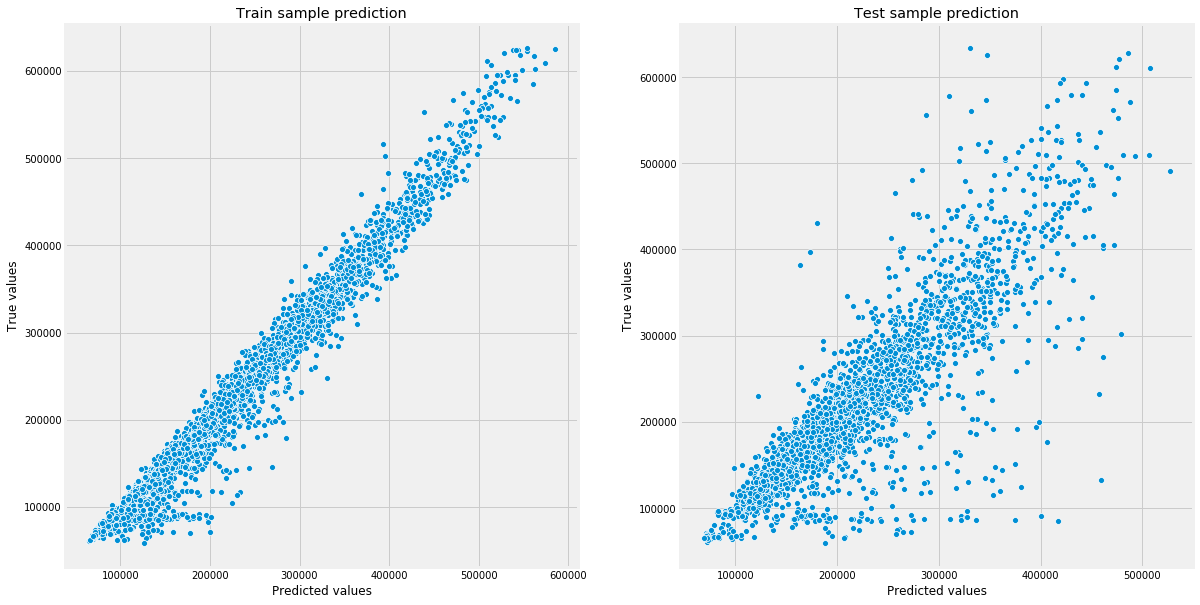

In [44]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

##### Кросс валидация

In [45]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(shuffle=True, random_state=21))
cv_score.mean()

0.7315394762896082

##### Важность фичей, как и следовало предположить наша гипер-фича имеет топ 1

In [46]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by = 'importance', ascending = False)

,feature_name,importance
3,Square,0.235401
4,LifeSquare,0.114397
2,Rooms,0.112687
13,Social_2,0.076380
12,Social_1,0.072421
14,Social_3,0.060987
1,DistrictId,0.053128
5,KitchenSquare,0.046164
9,Ecology_1,0.039282
8,HouseYear,0.037674


### Прогнозирование на тестовом датасете

> 1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
> 2. Не потерять и не перемешать индексы от примеров при построении прогнозов
> 3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [47]:
df_test.head().sort_values(by = 'Id', ascending = True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,E_2,E_3,S_2
0,725,58,2,49.882643,30.854083,6.0,6,14,1972,0.310199,...,11.0,2748.0,1.0,900.0,0.0,0.0,B,1,1,1
2,5480,190,1,52.773893,15.948246,12.0,2,5,1977,0.000000,...,30.0,7538.0,87.0,810.0,5.0,5.0,B,1,1,1
4,14275,27,1,47.527111,28.498550,6.0,17,17,2017,0.072158,...,2.0,629.0,1.0,900.0,0.0,0.0,A,1,1,2
3,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,...,23.0,4583.0,3.0,900.0,3.0,3.0,B,1,1,1
1,15856,74,2,69.263183,50.234623,6.0,1,1,1977,0.075779,...,6.0,1437.0,3.0,900.0,0.0,2.0,B,1,1,1


##### Удалим ненужные колонки

In [48]:
df_test = df_test.drop('Shops_2', axis=1)

In [49]:
df_test = df_test.drop('Ecology_2', axis=1)

In [50]:
df_test = df_test.drop('Ecology_3', axis=1)

##### Проверим что нет null значений

In [51]:
df_test.isnull().any()

Id               False
DistrictId       False
Rooms            False
Square           False
LifeSquare       False
KitchenSquare    False
Floor            False
HouseFloor       False
HouseYear        False
Ecology_1        False
Social_1         False
Social_2         False
Social_3         False
Healthcare_1     False
Helthcare_2      False
Shops_1          False
E_2              False
E_3              False
S_2              False
dtype: bool

##### Сделаем предсказания цен

In [52]:
a = rf_model.predict(df_test)

In [53]:
a = pd.DataFrame(a,columns=['Price'])
a.head()

,Price
0,150233.615633
1,207582.130511
2,237536.385844
3,232134.506643
4,134087.351322


##### Проверим длинну нашего датафрейма

In [54]:
len(a)

5000

##### объединим нужные колонки и выгрузим в файл

In [55]:
result = pd.concat([df_test['Id'].astype(int) , a['Price']], axis=1, sort=False)

result.to_csv(filename,index=False,encoding='utf-8')